---
# 10 Food classes Feature Extraction project
---

In [1]:
import tensorflow as tf

In [2]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")
else:
    print("GPU is not available.")

TensorFlow version: 2.10.0
Num GPUs Available:  1
GPU is available.


In [3]:
# Are we using a GPU?
!nvidia-smi

Tue Jul 16 20:07:55 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.70                 Driver Version: 560.70         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   65C    P8             15W /   84W |    5989MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## How many images in each folder?

In [4]:
import os

In [5]:
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'. ")

There are 2 directories and 0 images in '10_food_classes_10_percent'. 
There are 10 directories and 0 images in '10_food_classes_10_percent\test'. 
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'. 
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'. 
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'. 
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'. 
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'. 
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'. 
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'. 
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'. 
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'. 
There are 0 directories and 250 images in '10_food_classes

# Create data loaders (Preparing the data)

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
IMG_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

print("Train images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMG_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")
print("Test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = IMG_SHAPE,
                                             batch_size = BATCH_SIZE,
                                             class_mode = "categorical")

Train images:
Found 750 images belonging to 10 classes.
Test images:
Found 2500 images belonging to 10 classes.


# Creating models using Tensorflow Hub

Two models from TensorFlow Hub:

1. **ResNetV2** - a state of the art computer vision model architecture.
2. **EfficientNet** - a state of the art computer vision architecture.

In [8]:
import tensorflow_hub as hub
from tensorflow.keras import layers

In [9]:
tf.__version__

'2.10.0'

In [10]:
# Resnet 50 V2 feature vector 
resnet_url = "https://kaggle.com/models/google/resnet-v2/TensorFlow2/50-feature-vector/1"

# EffNetV2-B0 for ImageNet1k
efficientnet_url = "https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet1k-b0-classification/2"

## Create a function for models

In [11]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMG_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

# ResNetV2 model

## 1. Create the model

In [12]:
resnet_model = create_model(resnet_url, num_classes=train_data.num_classes)

## 2. Compile the model

In [13]:
resnet_model.compile(loss = "categorical_crossentropy",
                     optimizer = "Adam",
                     metrics = ["accuracy"])

## 3. Fit the model

In [14]:
history_resnet = resnet_model.fit(train_data,
                                  epochs = 5,
                                  steps_per_epoch=len(train_data),
                                  validation_data= test_data,
                                  validation_steps=len(test_data))

Epoch 1/5
24/24 [==============================] - 35s 856ms/step - loss: 1.9183 - accuracy: 0.3533 - val_loss: 1.1654 - val_accuracy: 0.6416
Epoch 2/5
24/24 [==============================] - 13s 543ms/step - loss: 0.8875 - accuracy: 0.7213 - val_loss: 0.8505 - val_accuracy: 0.7284
Epoch 3/5
24/24 [==============================] - 15s 635ms/step - loss: 0.6147 - accuracy: 0.8347 - val_loss: 0.7630 - val_accuracy: 0.7568
Epoch 4/5
24/24 [==============================] - 15s 653ms/step - loss: 0.4745 - accuracy: 0.8733 - val_loss: 0.7075 - val_accuracy: 0.7692
Epoch 5/5
24/24 [==============================] - 15s 642ms/step - loss: 0.3770 - accuracy: 0.9147 - val_loss: 0.6717 - val_accuracy: 0.7748


# Analysis of Loss and Accuracy over Epochs

In [15]:
import matplotlib.pyplot as plt

In [16]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();
     

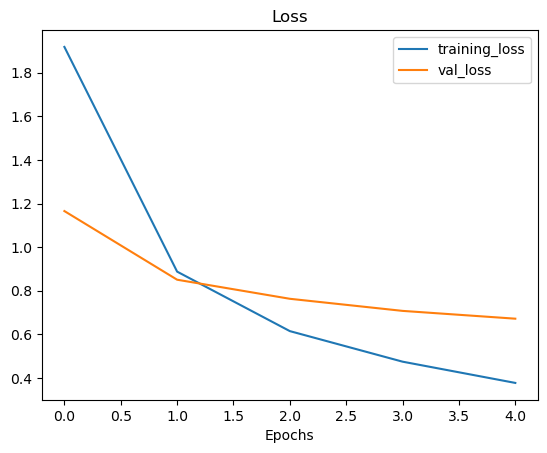

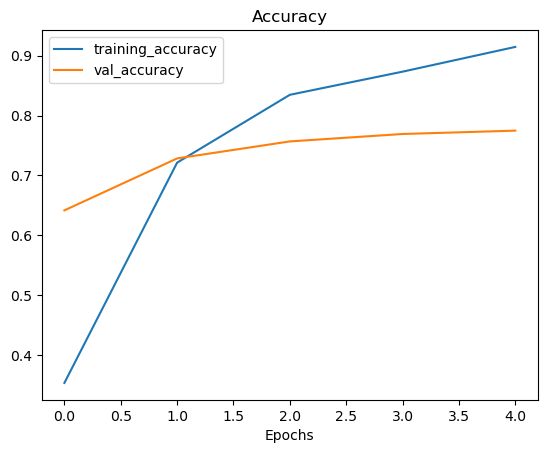

In [17]:
plot_loss_curves(history_resnet)

# EfficientNet

## 1. Creat the model

In [18]:
efficientnet_model = create_model(efficientnet_url,train_data.num_classes)

## 2. Compile the model

In [19]:
efficientnet_model.compile(loss = "categorical_crossentropy",
                           optimizer = "Adam",
                           metrics = ["accuracy"])

## 3. Fit the model

In [21]:
history_efficientnet = efficientnet_model.fit(train_data,
                                              epochs = 5,
                                              steps_per_epoch=len(train_data),
                                              validation_data=test_data,
                                              validation_steps= len(test_data))

Epoch 1/5
24/24 [==============================] - 18s 540ms/step - loss: 2.0083 - accuracy: 0.3547 - val_loss: 1.1912 - val_accuracy: 0.6060
Epoch 2/5
24/24 [==============================] - 11s 465ms/step - loss: 1.0505 - accuracy: 0.6520 - val_loss: 0.8977 - val_accuracy: 0.6960
Epoch 3/5
24/24 [==============================] - 11s 457ms/step - loss: 0.7832 - accuracy: 0.7533 - val_loss: 0.7978 - val_accuracy: 0.7276
Epoch 4/5
24/24 [==============================] - 11s 467ms/step - loss: 0.6351 - accuracy: 0.8213 - val_loss: 0.7653 - val_accuracy: 0.7428
Epoch 5/5
24/24 [==============================] - 11s 472ms/step - loss: 0.5535 - accuracy: 0.8347 - val_loss: 0.7326 - val_accuracy: 0.7540


# Analysis of Loss and Accuracy over Epochs

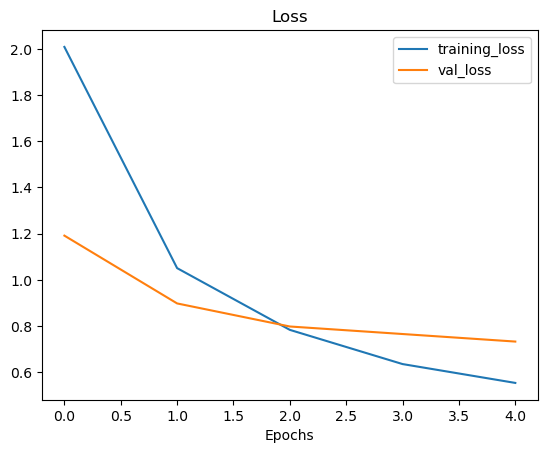

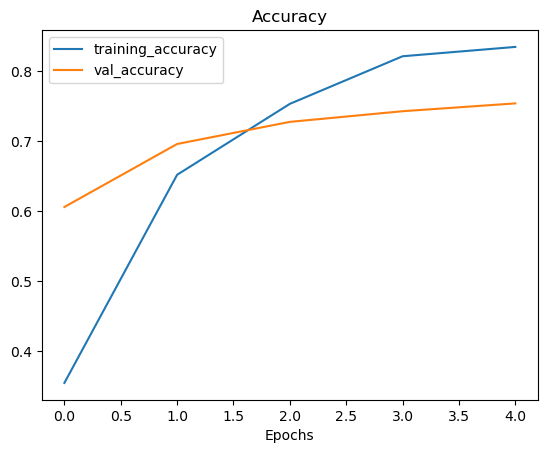

In [22]:
plot_loss_curves(history=history_efficientnet)

The ResNetV250 model does better than the EfficientNetB0 model! Achieving over 85% accuracy on the test set...again with only 10% of the training data.